In [169]:
!pip install google-cloud-bigquery
!pip install pandas-gbq
!pip install statsforecast

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [171]:
project_id = 'desafio-lighthouse-juliaertel'
schema_id = 'dbt_marts'
fact_table = 'fact_order'
dim_customer = 'dim_customer'
dim_product = 'dim_product'
dim_territory = 'dim_region'

In [172]:
client = bigquery.Client(project=project_id)

In [173]:
fact = client.query(f"select * from {schema_id}.{fact_table}").to_dataframe()
fact.head()

,product_fk,salesorderdetailid,productid,customer_fk,creditcard_fk,salesperson_fk,address_fk,salesorderid,orderqty,unitprice,unitpricediscount,order_status,taxamt,freight,totaldue,order_date,due_date
0,8d824db20a80d5aa28288e7de078e138,105887,878,c6ba20127a451f82c988f238c7b396ff,0359c586c3f41437140b540d53747b6b,None,c8d017c9ee52960412b0590f0c17d01f,69908,1,21.98,0.0,5,9.7552,3.0485,134.7437,2014-04-04 00:00:00+00:00,2014-04-16 00:00:00+00:00
1,44950ed9da4b68529ddff2dba7cdb6b0,105812,870,4426eb2f2b9790f7787372ab7c717d4f,b075cd7295a4d2c04413f5a2c70d59b1,None,e050af40e164ac289029c6823ebac2bc,69876,1,4.99,0.0,5,190.3160,59.4738,2628.7398,2014-04-04 00:00:00+00:00,2014-04-16 00:00:00+00:00
2,b6041c576ac842ef0767c33b2df2d40e,105826,711,9ab9ac4f0b1665d775f68e417736f87c,80e84b942bd938fd6849ccbcc5ce6ea8,None,4365aff682c1dc7963a461d525cc39ff,69880,1,34.99,0.0,5,47.9984,14.9995,662.9779,2014-04-04 00:00:00+00:00,2014-04-16 00:00:00+00:00
3,b6041c576ac842ef0767c33b2df2d40e,105826,711,9ab9ac4f0b1665d775f68e417736f87c,80e84b942bd938fd6849ccbcc5ce6ea8,None,85079ad4bfab07a4345fb9b829475792,69880,1,34.99,0.0,5,47.9984,14.9995,662.9779,2014-04-04 00:00:00+00:00,2014-04-16 00:00:00+00:00
4,76a4f679f278eb54d067004009e2fc49,105845,875,a725a3998cbe4aa5e1db66887bd6a230,023f74dd0180740041cb8d74b8c74cf9,None,337fa4fc12e35d6345fdc6582ee5964a,69887,1,8.99,0.0,5,6.3184,1.9745,87.2729,2014-04-04 00:00:00+00:00,2014-04-16 00:00:00+00:00


In [67]:
customer = client.query(f"select * from {schema_id}.{dim_customer}").to_dataframe()
customer.head()

,customer_sk,customerid,storeid,businessentityid,personid,territoryid,name_store,full_name,email,persontype,emailpromotion
0,7914d14f16ae05a96ed7de228ea82533,11529,<NA>,<NA>,6261,1,None,Austin L Bryant,austin14@adventure-works.com,IN,0
1,3c645a6d5cd7dce6ff1086a766b35cf8,11620,<NA>,<NA>,11700,1,None,Megan M Rodriguez,megan23@adventure-works.com,IN,0
2,d75ce4a79b5135b0e0f2a0b5caa8b5bb,11735,<NA>,<NA>,2858,1,None,Sydney K Gray,sydney16@adventure-works.com,IN,0
3,6177ad82df167ddf319c0c5f0bbd3134,11985,<NA>,<NA>,8130,1,None,Melanie A Hughes,melanie27@adventure-works.com,IN,0
4,dbacbc4b95ee051a314d1f370ef07719,12057,<NA>,<NA>,9407,1,None,Madeline M Collins,madeline2@adventure-works.com,IN,0


In [68]:
product = client.query(f"select * from {schema_id}.{dim_product}").to_dataframe()
product.head()

,product_sk,productid,name_product,standardcost,listprice,productline,style
0,2ad5938c85bdbe8bb33617303e0ad6d7,952,Chain,8.9866,20.24,None,None
1,6de4c9a15ac372fecff2df524371d57b,995,ML Bottom Bracket,44.9506,101.24,None,None
2,14bd4c26ec4b8a38a02758ace6872c78,806,ML Headset,45.4168,102.29,None,None
3,7a5ee687074d714b077245716b5739e4,950,ML Crankset,113.8816,256.49,None,None
4,09c1b2e9339035f9dcfd660893088aa6,807,HL Headset,55.3801,124.73,None,None


In [69]:
territory = client.query(f"select * from {schema_id}.{dim_territory}").to_dataframe().rename({'name': 'territoryname'}, axis=1)
territory.head()

,address_sk,addressid,stateprovinceid,countryregioncode,territoryid,territory_name,name_state,country_name
0,012ad28b23fa3ef19a08eb616faadcde,526,1,CA,7,France,Alberta,Canada
1,012ad28b23fa3ef19a08eb616faadcde,15731,1,CA,7,France,Alberta,Canada
2,012ad28b23fa3ef19a08eb616faadcde,475,1,CA,7,France,Alberta,Canada
3,012ad28b23fa3ef19a08eb616faadcde,546,1,CA,7,France,Alberta,Canada
4,012ad28b23fa3ef19a08eb616faadcde,505,1,CA,7,France,Alberta,Canada


In [174]:
fact['salesperson_fk'] = fact['salesperson_fk'].fillna('Online')

In [175]:
fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213170 entries, 0 to 1213169
Data columns (total 17 columns):
 #   Column              Non-Null Count    Dtype              
---  ------              --------------    -----              
 0   product_fk          1213170 non-null  object             
 1   salesorderdetailid  1213170 non-null  Int64              
 2   productid           1213170 non-null  Int64              
 3   customer_fk         1213170 non-null  object             
 4   creditcard_fk       1187440 non-null  object             
 5   salesperson_fk      1213170 non-null  object             
 6   address_fk          1213170 non-null  object             
 7   salesorderid        1213170 non-null  Int64              
 8   orderqty            1213170 non-null  Int64              
 9   unitprice           1213170 non-null  float64            
 10  unitpricediscount   1213170 non-null  float64            
 11  order_status        1213170 non-null  Int64              
 12  

In [176]:
fact['order_date'] = pd.to_datetime(fact['order_date']).dt.to_period('M')

<ipython-input-176-571b8a4839df>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fact['order_date'] = pd.to_datetime(fact['order_date']).dt.to_period('M')


In [177]:
grouped_month = fact.groupby('order_date')[['orderqty']].sum().reset_index()
grouped_month

,order_date,orderqty
0,2011-05,8250
1,2011-06,1410
2,2011-07,22090
3,2011-08,29040
4,2011-09,1570
5,2011-10,53820
6,2011-11,2300
7,2011-12,10400
8,2012-01,39670
9,2012-02,14420


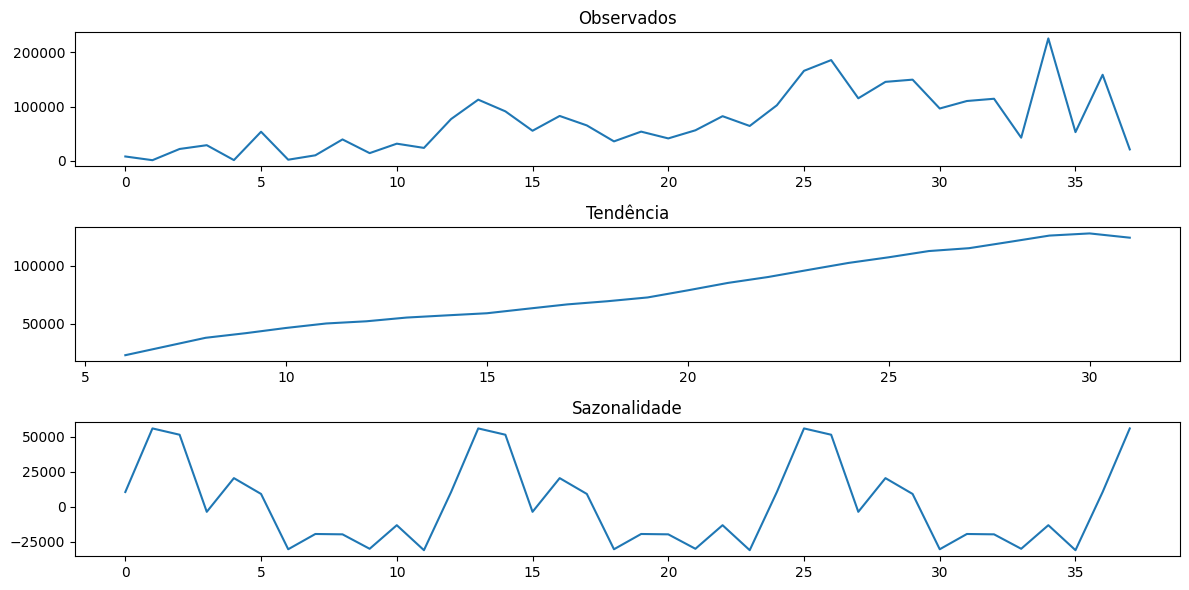

In [178]:
result = seasonal_decompose(grouped_month['orderqty'], model='additive', period=12)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax1 = result.observed.plot(ax=ax[0])
ax1.set_title('Observados')
ax2 = result.trend.plot(ax=ax[1])
ax2.set_title('Tendência')
ax3 = result.seasonal.plot(ax=ax[2])
ax3.set_title('Sazonalidade')

plt.tight_layout()
plt.show()

In [179]:
grouped_month['order_date'] = grouped_month['order_date'].dt.to_timestamp()

In [180]:
grouped_month['unique_id'] = 'total'

In [181]:
grouped_month = grouped_month.rename({'order_date': 'ds', 'orderqty': 'y'}, axis=1)

In [238]:
y_test = grouped_month.tail(6)
y_train = grouped_month.drop(y_test.index)

In [239]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         32 non-null     datetime64[ns]
 1   y          32 non-null     Int64         
 2   unique_id  32 non-null     object        
dtypes: Int64(1), datetime64[ns](1), object(1)
memory usage: 928.0+ bytes


In [240]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='MS'
)

In [241]:
sf.fit(y_train)

StatsForecast(models=[AutoARIMA])

In [242]:
predictions = sf.predict(h=10, level=[95])

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


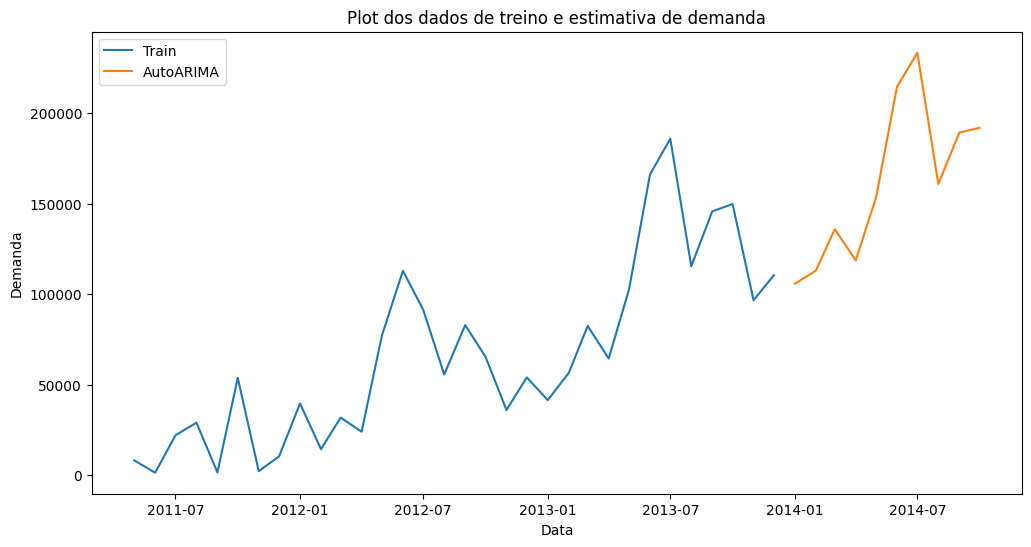

In [243]:
plt.figure(figsize=(12, 6))
plt.title('Plot dos dados de treino e estimativa de demanda')
ax1 = sns.lineplot(data=y_train, x='ds', y='y', label='Train')
ax2 = sns.lineplot(data=predictions, x='ds', y='AutoARIMA', label='AutoARIMA')
plt.ylabel('Demanda')
plt.xlabel('Data')
plt.show()

In [244]:
print(predictions)

                  ds      AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
unique_id                                                            
total     2014-01-01  105787.906250     50077.664062    161498.156250
total     2014-02-01  112986.187500     54068.386719    171903.984375
total     2014-03-01  135892.609375     74862.281250    196922.921875
total     2014-04-01  118731.828125     50008.753906    187454.890625
total     2014-05-01  153422.687500     81438.429688    225406.953125
total     2014-06-01  214629.968750    140128.359375    289131.593750
total     2014-07-01  233394.687500    155369.265625    311420.093750
total     2014-08-01  160844.156250     80296.296875    241392.015625
total     2014-09-01  189270.734375    106590.226562    271951.218750
total     2014-10-01  191937.281250    107034.093750    276840.468750


In [245]:
predictions = predictions.merge(y_test, on='ds')

In [247]:
predictions['abs_pct_error'] = abs((predictions['AutoARIMA'] - predictions['y']) / predictions['y'] * 100)
predictions

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,y,unique_id,abs_pct_error
0,2014-01-01,105787.906250,50077.664062,161498.156250,114630,total,7.713595
1,2014-02-01,112986.187500,54068.386719,171903.984375,42870,total,163.555371
2,2014-03-01,135892.609375,74862.281250,196922.921875,225820,total,39.822598
3,2014-04-01,118731.828125,50008.753906,187454.890625,53130,total,123.474173
4,2014-05-01,153422.687500,81438.429688,225406.953125,158840,total,3.410547
5,2014-06-01,214629.968750,140128.359375,289131.593750,21300,total,907.652435


In [248]:
print(f"MAE = {mean_absolute_error(predictions['y'], predictions['AutoARIMA'])}")
print(f"RMSE = {np.sqrt(mean_squared_error(predictions['y'], predictions['AutoARIMA']))}")

MAE = 72205.796875
RMSE = 95560.47116963945
